# SNAX package tutorial

In [1]:
from snewpy.neutrino import Flavor
import os
from tqdm.notebook import tqdm
import numpy as np
from multimessenger.supernova import Supernova_Models as sn
from multimessenger.supernova.Plotter import Plotter
# import plotly.express as px
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

The `SNAX` is a wrapper around `snewpy` and it allows to compute CEvNS rates for all the snewpy models.

In [2]:
sn.models_list

['Bollig_2016',
 'Fornax_2019',
 'Fornax_2021',
 'Kuroda_2020',
 'Nakazato_2013',
 'OConnor_2013',
 'OConnor_2015',
 'Sukhbold_2015',
 'Tamborra_2014',
 'Walk_2018',
 'Walk_2019',
 'Warren_2020',
 'Zha_2021']

Each model contains variuous simulations with e.g. different EoS, or different progenitor properties. <br>
When only `model_name` is passed to `sn.Models()` it displays the existing files and asks you to select one. Otherwise, `filename` or `index` can be passed. <br>
Once the model is executed, and after every heavy computation the data is saved, and the next time it is directly fetched from the stored data. <br>
The output folder can be specified with the `storage` argument.

In [3]:
# A.delete_object()

In [4]:
A = sn.Models(model_name='Nakazato_2013', index=9)

> You chose ~wisely~ ->	   [9]	nakazato-shen-z0.02-t_rev300ms-s20.0.fits
> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev300ms-s20_0_fits.pickle!



The object itself, has a nice representation which can be displayed by just executing itself. Here, the `executed` refers to rate calculations. Once this is done, this param updates and rates are stored. <br>
One can also keep track of the history by checking `A.display_history` to see when certain actions were performed.

In [5]:
A

**Nakazato_2013 Model**: nakazato-shen-z0.02-t_rev300ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.02 |
|Revival time | $300$ $\mathrm{ms}$|
|composite | Xenon|
|duration | 20.05 s|
|distance | 10.0 kpc|
|volume | 5.9 t|
|executed | False|

In [6]:
A.display_history

,date,version,user,history
0,2022/08/25 - 08:37 UTC,1.2.1,melih,Data Saved!


In [7]:
A.compute_rates();

Computing for all isotopes:   0%|          | 0/9 [00:00<?, ?it/s]

Xe124:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe126:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe128:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe129:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe130:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe131:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe132:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe134:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

Xe136:   0%|          | 0/4 [00:00<?, ?it/s]

$\nu_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_e$:   0%|          | 0/391 [00:00<?, ?it/s]

$\nu_x$:   0%|          | 0/391 [00:00<?, ?it/s]

$\overline{\nu}_x$:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev300ms-s20_0_fits.pickle!

> Rates are computed at the source for 1 atom see rateper_Er/t attr (use scale_rates() for distance & volume)


The object represantation now contains another row `SN_rate` this is the total number of expected events from the given model with the given parameters e.g. distance and volume.

In [8]:
A

**Nakazato_2013 Model**: nakazato-shen-z0.02-t_rev300ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | SHEN |
|Metallicity | 0.02 |
|Revival time | $300$ $\mathrm{ms}$|
|composite | Xenon|
|duration | 20.05 s|
|distance | 10.0 kpc|
|volume | 5.9 t|
|executed | True|
|SN rate | 61 ct|

In [9]:
A.display_history

,date,version,user,history
0,2022/08/25 - 08:37 UTC,1.2.1,melih,Data Saved!
1,2022/08/25 - 08:38 UTC,1.2.1,melih,Fluxes computed!
2,2022/08/25 - 08:38 UTC,1.2.1,melih,Data Saved!


### Plotter

One can also get a plotter, which takes the model object as input and allows for easy plotting. 

In [11]:
plotter = Plotter(A)

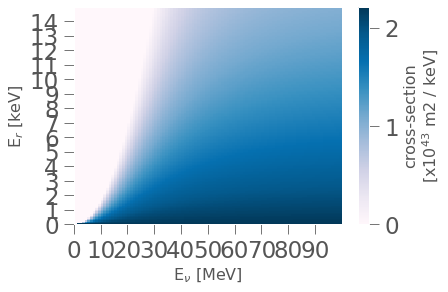

In [11]:
# plotter.plot_cross_section_fantastic()
plotter.plot_cross_section();

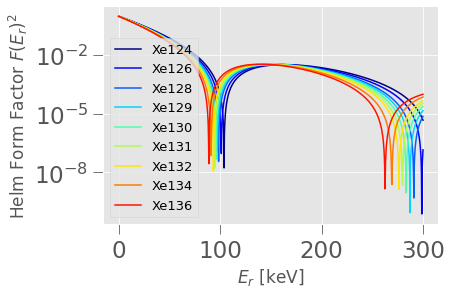

In [12]:
plotter.plot_form_factor()

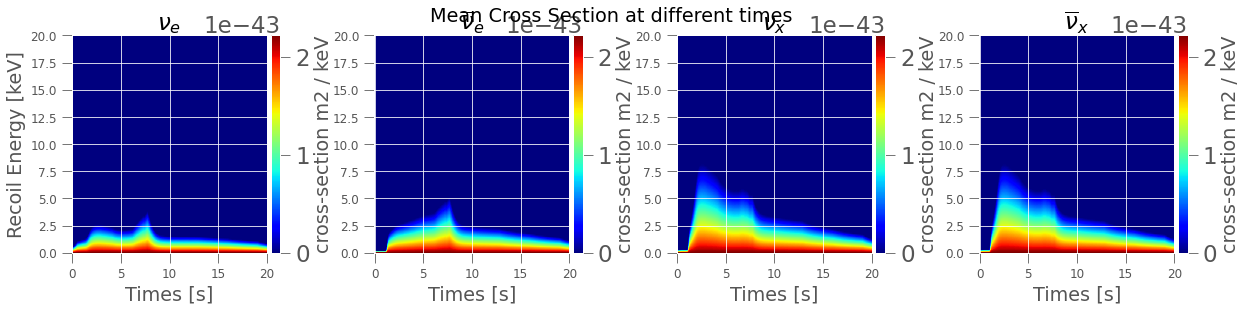

In [13]:
plotter.plot_mean_cross_section();

In [14]:
# plotter.plot_recoil_spectrum()

In [15]:
# # not all models have same attributes
# # plotter.plot_mean_cross_section(); # --> doesn't work as there are no meanE attribute in Fornax
# B = sn.Models(model_name='Nakazato_2013', index=10)
# plotter_B = Plotter(B)
# plotter_B.plot_mean_cross_section();
# plotter_B.plot_params()

In [16]:
# plotter.plot_sampled_data(50000, dtype="time", xscale="log");

In [17]:
# plotter.plot_sampled_data(50000, xscale='lin');

# Scale

The rates are computed at the source and for  single atom for convenience. The rates are returned as object attributes e.g.
```python
A.rateper_t
A.rateper_Er
A.rateper_t_iso
A.rateper_Er_iso
```
where the corresponding recoil energies and the times are also stored as attributes with units
```python
A.recoil_energies
A.time
```
Thus, the user can scale the rates for any number of Xenon atoms (or another atom), and for any distance (10kpc etc.). The volume is not scaled by default i.e. returned values are counts/distance/1 ton however, it is straightforward linear multiplication to scale for 7 or 40 tonnes.<br>
see `A.scale_rates()`.

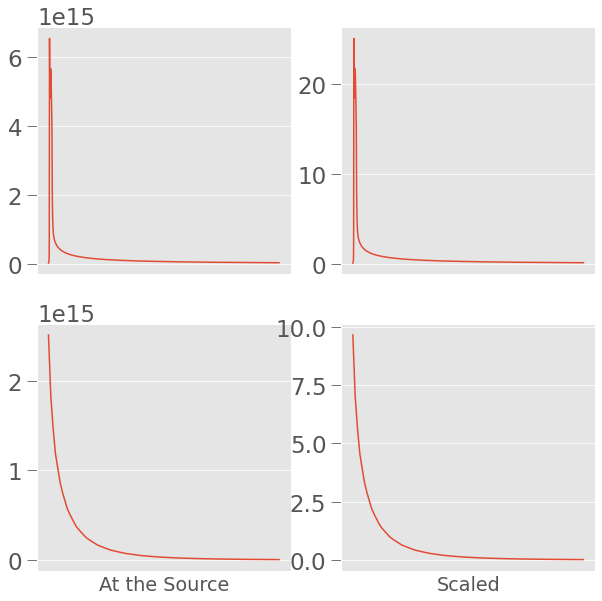

In [18]:
rates_scaled_Er, rates_scaled_t = A.scale_rates()

fig, ((ax1,ax2),((ax11,ax22))) = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
ax1.plot(A.model.time, A.rateper_t['Total'])
ax2.plot(A.model.time, rates_scaled_t['Total'])
ax11.plot(A.recoil_energies, A.rateper_Er['Total'])
ax22.plot(A.recoil_energies, rates_scaled_Er['Total'])
ax11.set_xlabel("At the Source")
ax22.set_xlabel("Scaled")
for ax in [ax1,ax2,ax11,ax22]:
    ax.set_xticks([])

The plotter has a tool to compute the total expected counts for given distances and given volumes. This already provides a nice way of benchmarking models.

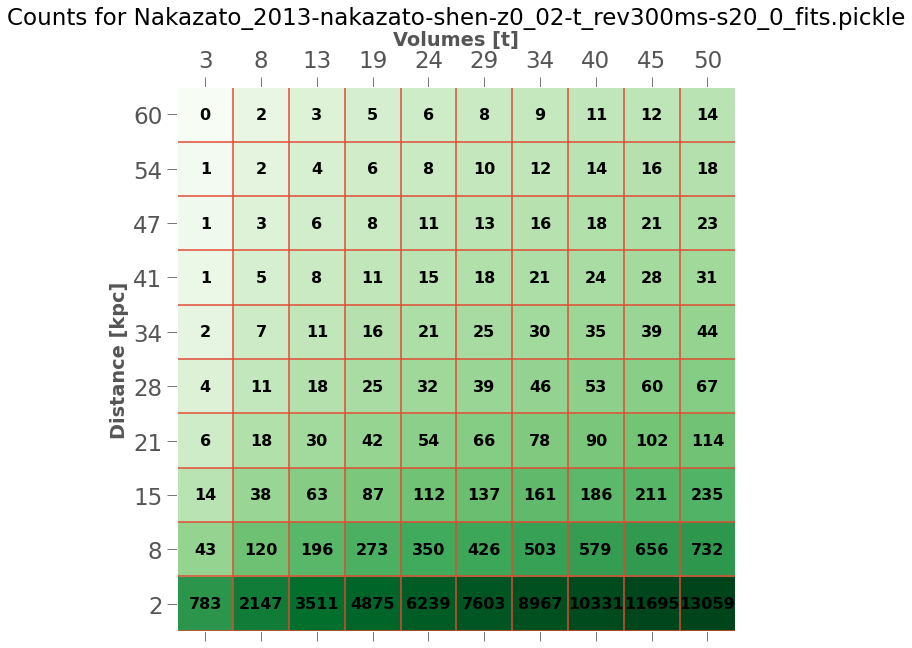

In [12]:
plotter.plot_counts()

## Simulate Signal with WFSim

These parts are better done in dali/midway. <br>


In [13]:
import nestpy
import pandas as pd
import straxen
downloader = straxen.MongoDownloader()

*** Detector definition message ***
You are currently using the default XENON10 template detector.



In [14]:
field_file="fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz"
field_map = straxen.InterpolatingMap(
                    straxen.get_resource(downloader.download_single(field_file),
                                         fmt="json.gz"),
                    method="RegularGridInterpolator")

nc = nestpy.NESTcalc(nestpy.DetectorExample_XENON10())
## not sure if nestpy RNG issue was solved, so randomize NEST internal state
for i in range(np.random.randint(100)):
    nc.GetQuanta(nc.GetYields(energy=np.random.uniform(10,100)))

*** Detector definition message ***
You are currently using the default XENON10 template detector.



Caution, the times need to be passed in nanoseconds!

### How to handle times 

Now we are going to create instructions for the SuperNova signal. However, for a real supernova we expect to have ~100 events. Thus those "realistic simulations" will be very sparse (nonetheless, still needed). <br>
This would be
```python
instr = generator_sn_instruction(energy_deposition=sampled_Er, timemode=sampled_t*1e9, n_tot=N_events, nc=nc, fmap=field_map)
```


We also want to study the general shape, for that, we simulate a signal with higher statistics. <br>
If we simulate thousands of events within 10 sec, buffer will crash. We need to simulate smarter, for this we will simulate total number of expected interactions within expected duration (e.g. 100 within 10 sec), then move the times and simulate again. <br>

For completeness the `generator_sn_instruction()` also has two more time modes "realistic" and "uniform" which are still useful to study time-independent aspects such as S2 shape. However, in order to build a trigger that is based on the rate, we need to contain time information.

In [15]:
A.single_rate

<Quantity 61.64255201 ct>

In [16]:
# _rate, _ = A.scale_rates(distance=10*u.kpc)
# nevents = int(np.trapz(_rate['Total'] * 7*u.t, A.recoil_energies).value)
nevents = int(A.single_rate.value)

sampled_Er = A.sample_data(nevents)
sampled_t = A.sample_data(nevents, dtype='time')

In [18]:
_instr = A.generate_instructions(energy_deposition=sampled_Er, 
                                 timemode=sampled_t*1e9, 
                                 n_tot=nevents, nc=nc, fmap=field_map)
df_realistic = pd.DataFrame(_instr)
print(f"Total duration {np.ptp(df_realistic['time'])*1e-9:.2f} seconds")
df_realistic

Total duration 18.07 seconds


,event_number,type,time,x,y,z,amp,recoil,e_dep,g4id,vol_id,local_field,n_excitons,x_pri,y_pri,z_pri
0,1,1,1019759121,-44.285782,12.174396,-39.651817,37,7,1.585966,0,0,23.180487,0,0.0,0.0,0.0
1,1,2,1019759121,-44.285782,12.174396,-39.651817,83,7,1.585966,0,0,23.180487,0,0.0,0.0,0.0
2,2,1,3174317834,-40.857258,3.523523,-121.740959,21,7,1.095382,0,0,22.244759,1,0.0,0.0,0.0
3,2,2,3174317834,-40.857258,3.523523,-121.740959,60,7,1.095382,0,0,22.244759,1,0.0,0.0,0.0
4,3,1,137797792,-1.776483,-58.729378,-13.381119,297,7,5.161301,0,0,27.388733,11,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,59,2,1296608801,41.037132,-10.320684,-120.052681,74,7,1.113509,0,0,22.184419,0,0.0,0.0,0.0
107,60,1,3279398168,-0.323675,47.976486,-105.270973,340,7,5.791203,0,0,21.845060,26,0.0,0.0,0.0
108,60,2,3279398168,-0.323675,47.976486,-105.270973,96,7,5.791203,0,0,21.845060,26,0.0,0.0,0.0
109,61,1,384094053,56.847984,13.036077,-10.081454,3,7,0.618396,0,0,29.800077,1,0.0,0.0,0.0


In [19]:
A.display_simulation_history

""


In [20]:
st = A.simulate_one(df_realistic, "Nakazato_single9")

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev300ms-s20_0_fits.pickle!



/home/melih/software/WFSim/wfsim/load_resource.py:262: RuntimeWarning: invalid value encountered in true_divide
  orig_aft_=np.mean((s2map_topeff_/s2map_toteff_)[s2map_toteff_>0.0])
*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/108 [00:00<?, ?it/s]

Source finished!
Nakazato_single9 is created! Returning context!


In [21]:
A.display_history

,date,version,user,history
0,2022/08/25 - 08:37 UTC,1.2.1,melih,Data Saved!
1,2022/08/25 - 08:38 UTC,1.2.1,melih,Fluxes computed!
2,2022/08/25 - 08:38 UTC,1.2.1,melih,Data Saved!
3,2022/08/25 - 09:10 UTC,1.2.1,melih,simulation Nakazato_single9 is requested!
4,2022/08/25 - 09:10 UTC,1.2.1,melih,Data Saved!


In [22]:
A.display_simulation_history

,,context hash,runid,date,user,model,single SN events,size
versions,index,,,,,,,
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1,0,rvchefp73l,Nakazato_single9,2022/08/25 - 09:10 UTC,melih,Nakazato_2013-nakazato-shen-z0_02-t_rev300ms-s...,61,111


It tracks the versions!

In [23]:
peak_basics = st.get_df("Nakazato_single2", "peak_basics")
peak_s1 = peak_basics[peak_basics['type'] == 1]
peak_s2 = peak_basics[peak_basics['type'] == 2]
peak_basics['type'].unique(), sum(peak_basics['type']==0), sum(peak_basics['type']==1), sum(peak_basics['type']==2)

Loading peak_basics: |          | 0.00 % [00:00<?]

(array([2, 1, 0], dtype=int8), 5, 39, 70)

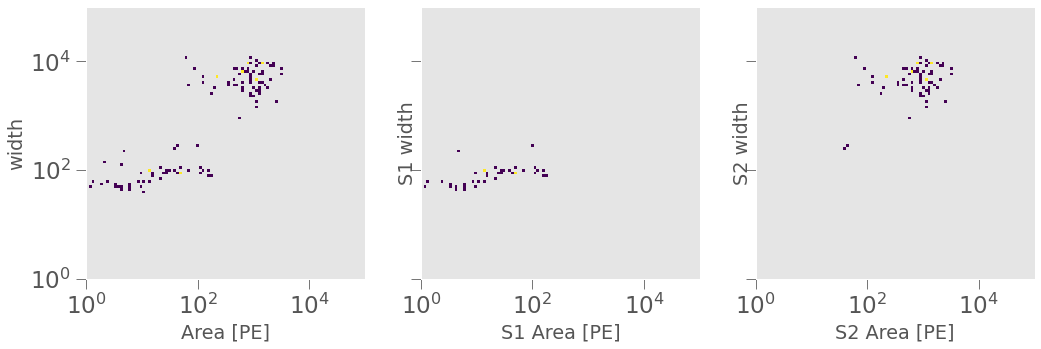

In [24]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics["area"], peak_basics["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s1["area"], peak_s1["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s2["area"], peak_s2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

In [26]:
import cutax, strax
st2 = cutax.contexts.xenonnt_sim_SR0v2_cmt_v8(cmt_run_id="026000", 
                                              output_folder=os.path.join(A.config['wfsim']['sim_folder'], "strax_data"))
# set s1 minimum coincidence to 0
st2.set_config({"s1_min_coincidence":0})

In [27]:
st2 = A.simulate_one(df_realistic, "Nakazato_single9_st2", st2)

> Saved at <self.storage>/Nakazato_2013-nakazato-shen-z0_02-t_rev300ms-s20_0_fits.pickle!



*** Detector definition message ***
You are currently using the default XENON10 template detector.



Simulating Raw Records:   0%|          | 0/108 [00:00<?, ?it/s]

Source finished!
Nakazato_single9_st2 is created! Returning context!


In [28]:
A.display_simulation_history

context hash  \
versions                                           index                
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0       rvchefp73l   
                                                   1       ibctvalxfl   

                                                                         runid  \
versions                                           index                         
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0          Nakazato_single9   
                                                   1      Nakazato_single9_st2   

                                                                            date  \
versions                                           index                           
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0      2022/08/25 - 09:10 UTC   
                                                   1      2022/08/25 - 09:18 UTC   

                                                           user  \
versions                                           index          
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0      melih   
                                                   1      melih   

                                                                                                      model  \
versions                                           index                                                      
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0      Nakazato_2013-nakazato-shen-z0_02-t_rev300ms-s...   
                                                   1      Nakazato_2013-nakazato-shen-z0_02-t_rev300ms-s...   

                                                         single SN events size  
versions                                           index                        
strax:1.2.3 straxen:1.8.3 cutax:1.13.0 wfsim:1.0.1 0                   61  111  
                                                   1                   61  111

One can see that the context hash is different

In [29]:
peak_basics2 = st2.get_df("Nakazato_single2", "peak_basics")
peak_s12 = peak_basics2[peak_basics2['type'] == 1]
peak_s22 = peak_basics2[peak_basics2['type'] == 2]

Loading peak_basics: |          | 0.00 % [00:00<?]

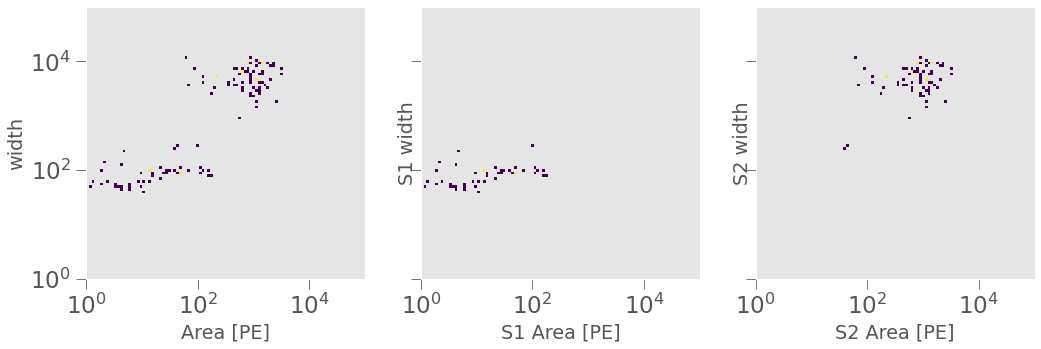

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(17,5), sharex=True, sharey=True)
ax0.grid(False); ax1.grid(False); ax2.grid(False)
ax0.hist2d(peak_basics2["area"], peak_basics2["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax0.set_xscale("log"); ax0.set_yscale("log")
ax0.set_xlabel("Area [PE]"); ax0.set_ylabel("width");


ax1.hist2d(peak_s12["area"], peak_s12["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax1.set_xscale("log"); ax1.set_yscale("log")
ax1.set_xlabel("S1 Area [PE]"); ax1.set_ylabel("S1 width");

ax2.hist2d(peak_s22["area"], peak_s22["range_50p_area"], 
           bins=(np.logspace(0,5,100),np.logspace(0,5,100)),
           norm=LogNorm());
ax2.set_xscale("log"); ax2.set_yscale("log")
ax2.set_xlabel("S2 Area [PE]"); ax2.set_ylabel("S2 width");

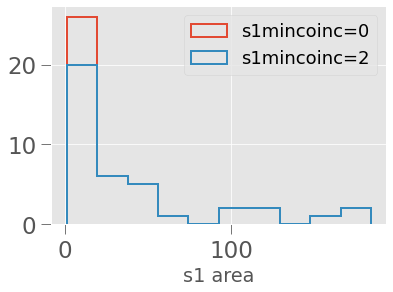

In [40]:
plt.hist(peak_s12['area'], bins=10, histtype='step', lw=2, label='s1mincoinc=0');
plt.hist(peak_s1['area'], bins=10, histtype='step', lw=2, label='s1mincoinc=2');
plt.xlabel('s1 area')
plt.legend();